# Noisy quantum evolution with Rydberg atoms


Noise is ubiquitous in quantum computers which affects the accuracy of the calculations they perform. Various sources could contribute to the noise in a quantum computer, including cosmic rays, disturbances caused by an approaching train, or even the ambient light of the room where the quantum computer sits. These sources of error could affect qubit lifetimes, gate fidelities, and the reliability of preparation and measurement. In previous notebooks, we have introduced [the noise models on Amazon Braket](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/braket_features/Noise_models/Noise_models_on_Amazon_Braket.ipynb) and [those on Rigetti](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/braket_features/Noise_models/Noise_models_on_Rigetti.ipynb), which focus on the noise models for gate-based devices. In this notebook, we will dive deep into several sources of noise for Rydberg devices, which have different underlying physics, and understand how they affect the analog Hamiltonian simulation (AHS) program running on these devices. In particular, we will use the coherent evolution of the Bell state of a pair Rydberg atoms under the AHS Hamiltonian to illustrate the effects of different noise sources."

## Creating and evolving a Bell state with Rydberg atoms

[Bell states](https://en.wikipedia.org/wiki/Bell_state) are a set of maximally entagled states of two qubits. Here, we consider creating and evolving a Bell state with Rydberg atoms in the presence of noise. We will see how noise affects the quality of the prepared Bell state and its quantum evolution. 

For a pair of atoms, their Rydberg Hamiltonian can be written as a $4\times4$ matrix in the basis of $\left\{|gg\rangle, |gr\rangle, |rg\rangle, |rr\rangle\right\}$
\begin{align}
H = 
\begin{bmatrix}
0 & \frac{\Omega}{2} & \frac{\Omega}{2} & 0 \\
\frac{\Omega}{2} & -\Delta & 0 & \frac{\Omega}{2}\\
\frac{\Omega}{2} & 0 & -\Delta & \frac{\Omega}{2}\\
0 & \frac{\Omega}{2} & \frac{\Omega}{2} & V-2\Delta
\end{bmatrix}.
\end{align}
Here $\Omega$ and $\Delta$ are the amplitude and detuning of a time-varying global driving field, and $V\equiv C_6/R^6$ is the interaction strength between the two atoms which depends on their distance $R$ and a constant $C_6\equiv 5.42\times10^{-24} \text{ rad m}^6/\text{s}$. To create a Bell state, we consider putting the two atoms within the Rydberg blockade radius. As discussed in [this notebook](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/00_Introduction_of_Analog_Hamiltonian_Simulation_with_Rydberg_Atoms.ipynb), if both atoms are subject to zero detuning ($\Delta=0$), it is very unlikely to excite both atoms to the Rydberg states simultaneously and effectively there are only three states in the Hilbert space, namely $|gg\rangle$, $|gr\rangle$ and $|rg\rangle$. Suppose the two atoms are initilized in the ground state and the amplitude of the driving field, which has duration $T$, satisfies (we will refer to the following quantity as amplitude area below)
\begin{align}
\int_{0}^T\Omega(t)dt = \frac{\pi}{\sqrt{2}},
\end{align}
then one can show that the final state of the two atoms is a Bell state, i.e.,
\begin{align}
|\phi_1\rangle = \exp\left\{-i
\begin{bmatrix}
0 & \frac{\pi}{2\sqrt{2}} & \frac{\pi}{2\sqrt{2}}\\
\frac{\pi}{2\sqrt{2}} & 0 & 0 \\
\frac{\pi}{2\sqrt{2}} & 0 & 0
\end{bmatrix}
\right\} 
\begin{bmatrix}
|gg\rangle \\
|gr\rangle \\
|rg\rangle
\end{bmatrix}
=-\frac{i}{\sqrt{2}}(|gr\rangle + |rg\rangle).
\end{align}


After the Bell state is created, we consider its evolution subject to a global driving field with nonzero amplitude and detuning. In particular, the detuing is set to a constant value that is *exactly* equal to the interaction between the two atoms, i.e., $V=\Delta$. In this case, because $-\Delta=-V\ll 0$, the states $\left\{|gr\rangle, |rg\rangle, |rr\rangle\right\}$ are at the energy levels much smaller than that of $|gg\rangle$, and hence the evolution is approximately governed by the $3\times3$ Hamiltonian
\begin{align}
H = 
\begin{bmatrix}
 -\Delta & 0 & \frac{\Omega}{2}\\
 0 & -\Delta & \frac{\Omega}{2}\\
 \frac{\Omega}{2} & \frac{\Omega}{2} & -\Delta
\end{bmatrix},
\end{align}
in the basis of $\left\{|gr\rangle, |rg\rangle, |rr\rangle\right\}$. With the initial state being the Bell state $|\phi_1\rangle$, we can solve the time-dependent wave function as (up to a global phase)
\begin{align}
|\psi(t)\rangle = \cos\frac{\Omega t}{\sqrt{2}}|\phi_1\rangle - \sin\frac{\Omega t}{\sqrt{2}}|rr\rangle.
\end{align}
It is clear that $|\psi(t=0)\rangle=|\phi_1\rangle$, and its evolution can be viewed as an oscillation between $|\phi_1\rangle$ itself and $|rr\rangle$. This demonstrates that, with strong global detuning applied to two atoms within the blockade radius, we can excite both atoms to the Rydberg states which is otherwise forbidden by the strong Rydberg blockade interaction.

Below we first exhibit a noiseless AHS program that realizes the creation and evolution of Bell states, followed by showing how to add various noise to the program and their impact to the result of the program. Finally we submit the noiseless AHS program to Aquila and compare the result to the noise simulation result. 

## Noiseless AHS program for creating and evolving a Bell state

In [1]:
from pprint import pprint as pp
from braket.aws import AwsDevice 

qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
capabilities = qpu.properties.paradigm

In [2]:
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from ahs_utils import show_global_drive, show_register, show_drive_and_local_detuning
from braket.ahs.driving_field import DrivingField
from braket.timings.time_series import TimeSeries

amplitude_max = float(capabilities.rydberg.rydbergGlobal.rabiFrequencyRange[-1])
detuning_slew_rate = float(capabilities.rydberg.rydbergGlobal.detuningSlewRateMax)
amplitude_slew_rate = float(capabilities.rydberg.rydbergGlobal.rabiFrequencySlewRateMax)
time_separation_min = float(capabilities.rydberg.rydbergGlobal.timeDeltaMin)
height = float(capabilities.lattice.area.height)
width = float(capabilities.lattice.area.width)
C6 = float(capabilities.rydberg.c6Coefficient)


def create_evolve_bell_states(
    atom_separation: float = 6.7e-6, # The separation of the two atoms used throughout the notebook
    amplitude_area: float = 0.0,
    if_show_global_drive: bool = False,
    if_parallel: bool = False,
    patch_separation: float = 24e-6,
) -> AnalogHamiltonianSimulation:
    """
    Return an AHS program to create and evolve a Bell state with Rydberg atoms

    Args:
        atom_separation (float): The separation of the two atoms
        amplitude_area (float): The area of the amplitude for the evolution
        if_show_global_drive (bool): If true, a figure for global drive will be shown
        if_parallel (bool): If true, multiple patches of the two atoms will be created,
            which is typically used when running simulation on the quantum hardware
        patch_separation (float): The vertical and horizontal separations of the patches

    Returns:
        (AnalogHamiltonianSimulation): The AHS program for creating and evolving a Bell state
    """    
    
    detuning_max = C6/(atom_separation**6)
    t_ramp_detuning = detuning_max / detuning_slew_rate
    t_ramp_detuning = max(t_ramp_detuning, time_separation_min)
    
    # Define register
    coords = [(0, 0), (0, atom_separation)]
    if if_parallel:
        # Extend along y direction
        n_height = int(height // (atom_separation + patch_separation))
        if n_height * (atom_separation + patch_separation) + atom_separation < height:
            n_height += 1
            
        for i in range(n_height-1):
            coords.append((0, patch_separation * (i+1)))
            coords.append((0, atom_separation + patch_separation * (i+1)))
            
        # Extend along x direction
        n_width = int(width // patch_separation)
        if n_width * patch_separation < width:
            n_width += 1
        
        for i in range(n_width-1):
            for j in range(n_height):
                coords.append((patch_separation * (i+1), patch_separation * j))
                coords.append((patch_separation * (i+1), atom_separation + patch_separation * j))
    
    register = AtomArrangement()
    for coord in coords:
        register.add(coord)

    # Prepare the Bell state
    amplitude = TimeSeries.trapezoidal_signal(np.pi/np.sqrt(2), amplitude_max, amplitude_slew_rate, time_separation_min=time_separation_min)
    detuning = TimeSeries.constant_like(amplitude, 0.0)
    phase = TimeSeries.constant_like(amplitude, 0.0)
    
    
    # Evolve
    if amplitude_area > 0:
        
        # Ramp up the detuning
        t_prep = amplitude.times()[-1]
        amplitude.put(t_prep + t_ramp_detuning, 0.0)
        detuning.put(t_prep + t_ramp_detuning, detuning_max)
        phase.put(t_prep + t_ramp_detuning, 0.0)

        amplitude_evolve = TimeSeries.trapezoidal_signal(amplitude_area, amplitude_max, amplitude_slew_rate, time_separation_min=time_separation_min)
        amplitude = amplitude.stitch(amplitude_evolve)
        detuning = detuning.stitch(TimeSeries.constant_like(amplitude_evolve, detuning_max))
        phase = phase.stitch(TimeSeries.constant_like(amplitude_evolve, 0.0))
    
    
    drive = DrivingField(amplitude=amplitude, phase=phase, detuning=detuning)
    
    if if_show_global_drive:
        show_global_drive(drive)
                
    program = AnalogHamiltonianSimulation(
        register = register,
        hamiltonian = drive
    )
    
    return program

def aggregate_counters(counters: dict[str, int]) -> dict[str, int]:
    
    states = ['gg', 'gr', 'rg', 'rr']
    counters2 = {state: 0 for state in states}    
    shots = 0
    for key, val in counters.items():
        for i in range(int(len(key)/2)):
            state = key[2*i:2*i+2]
            if state in counters2.keys():
                counters2[state] += val 
                shots += val
    
    for key, val in counters2.items():
        counters2[key] = val/shots
                
    return counters2

Below we show an example AHS program. The first part of the program creates a Bell state with zero detuning, and then the detuning is ramped up to a constant value followed by a trapezoidal waveform for the amplitude which is similar to that used to create the Bell state. The evolution of the Bell state can be realized by varying the area of the second trapezoidal waveform for the amplitude. We note that because of the finite ramping time of the amplitude, the evolution of the Bell state will have slight discrepancy compared to the ideal Rabi oscillation between $|\phi_1\rangle$ and $|rr\rangle$, as described above. But as the ramping time is only of the order of $10^{-8}$ seconds, the discprepancy is very small as we will see below.

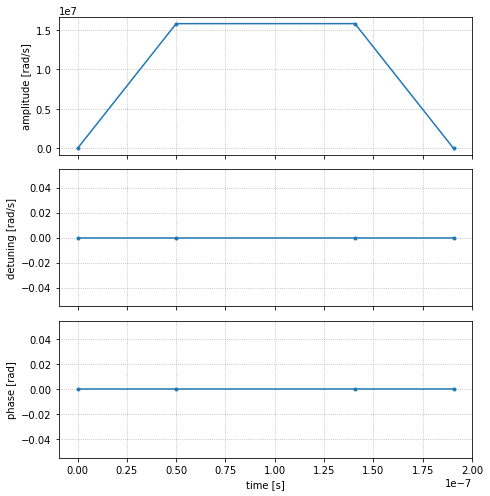

In [3]:
import numpy as np

program_1 = create_evolve_bell_states(amplitude_area = 0, if_show_global_drive=True, if_parallel=True) ;

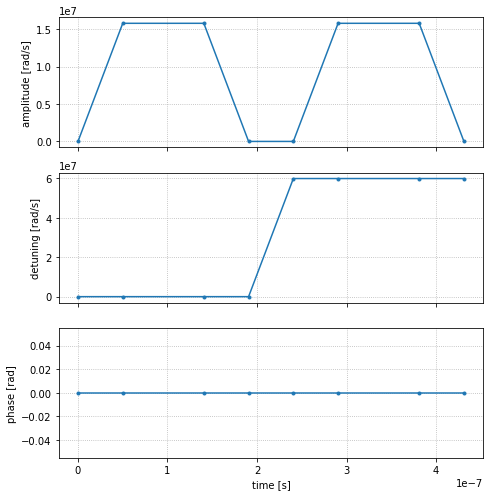

In [4]:
program_2 = create_evolve_bell_states(amplitude_area = np.pi/np.sqrt(2), if_show_global_drive=True, if_parallel=True) ;

In [5]:
sum(program_2.to_ir().setup.ahs_register.filling)

24

In [6]:
from braket.devices import LocalSimulator

simulator = LocalSimulator("braket_ahs_tn")

In [8]:
%%time 
task_1_tebd = simulator.run(program_1, steps=100, shots=1000, max_bond_dim=16, solver="tebd")

CPU times: user 137 ms, sys: 3.97 ms, total: 141 ms
Wall time: 1min 7s


In [36]:
aggregate_counters(task_1_tebd.result().get_counts())

{'gg': 0.006833333333333334,
 'gr': 0.49,
 'rg': 0.4915,
 'rr': 0.011666666666666667}

In [9]:
%%time 
task_1_tdvp = simulator.run(program_1, steps=100, shots=1000, max_bond_dim=16, solver="tdvp")

CPU times: user 138 ms, sys: 61 μs, total: 138 ms
Wall time: 1min 27s


In [37]:
aggregate_counters(task_1_tdvp.result().get_counts())

{'gg': 0.007166666666666667,
 'gr': 0.48783333333333334,
 'rg': 0.49191666666666667,
 'rr': 0.013083333333333334}

In [17]:
%%time 
task_2_tebd = simulator.run(program_2, steps=100, shots=1000, max_bond_dim=16, solver="tebd")

CPU times: user 138 ms, sys: 57 μs, total: 138 ms
Wall time: 1min 7s


In [38]:
aggregate_counters(task_2_tebd.result().get_counts())

{'gg': 0.005083333333333333,
 'gr': 0.00225,
 'rg': 0.0020833333333333333,
 'rr': 0.9905833333333334}

In [19]:
%%time 
task_2_tdvp = simulator.run(program_2, steps=100, shots=1000, max_bond_dim=16, solver="tdvp")

CPU times: user 273 ms, sys: 0 ns, total: 273 ms
Wall time: 1min 27s


In [39]:
aggregate_counters(task_2_tdvp.result().get_counts())

{'gg': 0.00375,
 'gr': 0.0019166666666666666,
 'rg': 0.0010833333333333333,
 'rr': 0.99325}

# Device emulation

In [7]:
task_1_emu = qpu.validate(program_1)

i am at braket_ahs_tn_noisy


Exception: 1 validation error for DeviceDrivingFieldValidator
__root__
  time point 2 (1.405975613341255E-7) of amplitude time_series is defined with too many digits; it must be an integer multiple of 1E-9 (type=value_error) (Aquila)

In [8]:
task_1_emu = qpu.validate(program_1.discretize(qpu))

In [9]:
program_1.to_ir().setup.ahs_register.sites

[[Decimal('0'), Decimal('0')],
 [Decimal('0'), Decimal('0.0000067')],
 [Decimal('0'), Decimal('0.000024')],
 [Decimal('0'), Decimal('0.0000307')],
 [Decimal('0'), Decimal('0.000048')],
 [Decimal('0'), Decimal('0.0000547')],
 [Decimal('0.000024'), Decimal('0.0')],
 [Decimal('0.000024'), Decimal('0.0000067')],
 [Decimal('0.000024'), Decimal('0.000024')],
 [Decimal('0.000024'), Decimal('0.0000307')],
 [Decimal('0.000024'), Decimal('0.000048')],
 [Decimal('0.000024'), Decimal('0.0000547')],
 [Decimal('0.000048'), Decimal('0.0')],
 [Decimal('0.000048'), Decimal('0.0000067')],
 [Decimal('0.000048'), Decimal('0.000024')],
 [Decimal('0.000048'), Decimal('0.0000307')],
 [Decimal('0.000048'), Decimal('0.000048')],
 [Decimal('0.000048'), Decimal('0.0000547')],
 [Decimal('0.000072'), Decimal('0.0')],
 [Decimal('0.000072'), Decimal('0.0000067')],
 [Decimal('0.000072'), Decimal('0.000024')],
 [Decimal('0.000072'), Decimal('0.0000307')],
 [Decimal('0.000072'), Decimal('0.000048')],
 [Decimal('0.00007

In [10]:
program_1_noisy = qpu.run_passes(program_1.discretize(qpu))
program_1_noisy.to_ir().setup.ahs_register.sites

[[Decimal('-1.0083082350828086E-8'), Decimal('7.766102118417925E-8')],
 [Decimal('-6.138617540293376E-8'), Decimal('0.000006787448923108186')],
 [Decimal('-1.9231883626334477E-7'), Decimal('0.000024170306272017107')],
 [Decimal('-1.740106645080155E-7'), Decimal('0.00003067735719539814')],
 [Decimal('6.053593170967198E-8'), Decimal('0.00004784819983757653')],
 [Decimal('1.781273553398041E-8'), Decimal('0.0000548142858704827')],
 [Decimal('0.000024025561505770348'), Decimal('1.3508650723305533E-7')],
 [Decimal('0.000024158181134493507'), Decimal('0.000006549631767695919')],
 [Decimal('0.000024073290734288604'), Decimal('0.00002411343342363793')],
 [Decimal('0.00002401728104574977'), Decimal('0.00003060937665590321')],
 [Decimal('0.000024000421502763266'), Decimal('0.000048040681359819186')],
 [Decimal('0.000023906022762193705'), Decimal('0.00005470171353962879')],
 [Decimal('0.000047971632342642975'), Decimal('6.32701392107153E-8')],
 [Decimal('0.00004794255522692256'), Decimal('0.000006

In [11]:
program_1.to_ir().hamiltonian.drivingFields[0].amplitude

PhysicalField(time_series=TimeSeries(values=[Decimal('0'), Decimal('15800000.0'), Decimal('15800000.0'), Decimal('0')], times=[Decimal('0'), Decimal('5E-8'), Decimal('1.405975613341255E-7'), Decimal('1.905975613341255E-7')]), pattern='uniform')

In [12]:
program_1_noisy.to_ir().hamiltonian.drivingFields[0].amplitude

PhysicalField(time_series=TimeSeries(values=[Decimal('0'), Decimal('484989.3404126533'), Decimal('993976.472194469'), Decimal('1402666.0458092014'), Decimal('1957604.9353365335'), Decimal('2415072.3696031384'), Decimal('2950609.6016971013'), Decimal('3426131.996362271'), Decimal('4076349.9251259575'), Decimal('4532518.5206167'), Decimal('5396575.3299689535'), Decimal('5688816.901321964'), Decimal('6356278.224566445'), Decimal('7106655.059402441'), Decimal('7446515.028273019'), Decimal('8052551.534021197'), Decimal('8738169.136384621'), Decimal('9707239.814110754'), Decimal('10186617.786899062'), Decimal('10898508.10086247'), Decimal('11506267.011217777'), Decimal('12444577.476549407'), Decimal('13114269.269833466'), Decimal('13782664.30347584'), Decimal('14476100.786683654'), Decimal('15286341.025501173'), Decimal('16491148.967812566'), Decimal('15629480.357552174'), Decimal('15539344.771750063'), Decimal('16108678.62560497'), Decimal('15354757.84626365'), Decimal('15680975.131761186')

In [25]:
%%time

task_1_emu = qpu.emulate(program_1.discretize(qpu), shots=100) # This uses tebd for now

CPU times: user 246 ms, sys: 437 ms, total: 683 ms
Wall time: 3min 19s


In [40]:
aggregate_counters(task_1_emu.result().get_counts())

{'gg': 0.10702341137123746,
 'gr': 0.411371237458194,
 'rg': 0.42725752508361203,
 'rr': 0.05434782608695652}

In [26]:
task_1_qpu = qpu.run(program_1.discretize(qpu), shots=100)
task_1_qpu.metadata()['quantumTaskArn']
# 'arn:aws:braket:us-east-1:545821822555:quantum-task/09be3e38-258a-4de7-ad81-1e79243da90b'


In [42]:
aggregate_counters(task_1_qpu.result().get_counts())

{'gg': 0.07796610169491526,
 'gr': 0.4228813559322034,
 'rg': 0.46864406779661016,
 'rr': 0.030508474576271188}

In [41]:
%%time

task_2_emu = qpu.emulate(program_2.discretize(qpu), shots=100) # This uses tebd for now

CPU times: user 238 ms, sys: 456 ms, total: 694 ms
Wall time: 3min 19s


In [43]:
aggregate_counters(task_2_emu.result().get_counts())

{'gg': 0.03177257525083612,
 'gr': 0.1262541806020067,
 'rg': 0.13712374581939799,
 'rr': 0.7048494983277592}

In [44]:
task_2_qpu = qpu.run(program_2.discretize(qpu), shots=100)
task_2_qpu.metadata()['quantumTaskArn']
# 'arn:aws:braket:us-east-1:545821822555:quantum-task/038d3559-6fe1-4b75-891a-294f350e6f4d'


In [46]:
aggregate_counters(task_2_qpu.result().get_counts())

{'gg': 0.08171861836562763,
 'gr': 0.11710193765796124,
 'rg': 0.10614995787700084,
 'rr': 0.6950294860994103}